In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Lastnosti Fourierove transformacije

Na tej vaji si bomo iz praktičnega vidika pogledali lastnosti Fourierove transformacije, s katerimi imamo pogosto opravka pri merjenju signalov:

* linearnost,
* časovno skaliranje,
* (časovni obrat),
* časovni premik,
* (amplitudna modulacija - frekvenčni premik),
* odvajanje in integriranje,
* konvolucija in produkt funkcij.



## Naloga

:::{admonition} Domača naloga
:class: warning

Z uporabo generatorja signalov in zajemnega sistema Arduino pripravite signale, s katerimi boste demonstrirali lastnosti Fourierove transformacije, določene v podatkih naloge.

**Priprave in zajema signalov se lotite v skupini** s kolegi, ki imajo enake podatke.
LabView program za zajem lahko prenesete v obliki {download}`zip arhiva<./data/03/labview_zajem.zip>`.

Pripravite kratko poročilo *(obseg od 3 do 10 celic s kodo v okolju Jupyter Notebook)*, iz katerega naj bodo razvidni podatki naloge (iz tabele), ter da ste vse parametre in zahteve naloge naloge tudi upoštevali. Demonstrirajte vpliv izbrane lastnosti Fourierove transformacije na zajeta signala (zglede poiščite v predlogah za predavanja in vaje).

Poročilo oddajte v `.pdf` obliki (glejte [navodila za oddajo domačih nalog](intro-domace-naloge)).

**Dodatek**: Raziščite lastnost konvolucije / množenja signalov v povezavi s Fourierovo transformacijo in jo prikažite ter komentirajte na primeru uporabe oken (uporabite [`scipy.signal.windows`](https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows)) z enim izmed signalov, zajetih na vaji.

:::

---

## Linearnost

:::{admonition} Linearnost
:class: note

$$
\mathcal{F}\{a\,x(t)+b\,y(t)\} = a\,X(f) + b\,Y(f).
$$
:::

In [2]:
fs = 100 # Hz
dt = 1 / fs
t = np.arange(0, 2, dt)
A = 5
p = 4
o = 2

In [3]:
x = A * np.sin(2*np.pi*t * p) + o*2
y = 2*A * signal.square(2*np.pi*t * p/2) + o

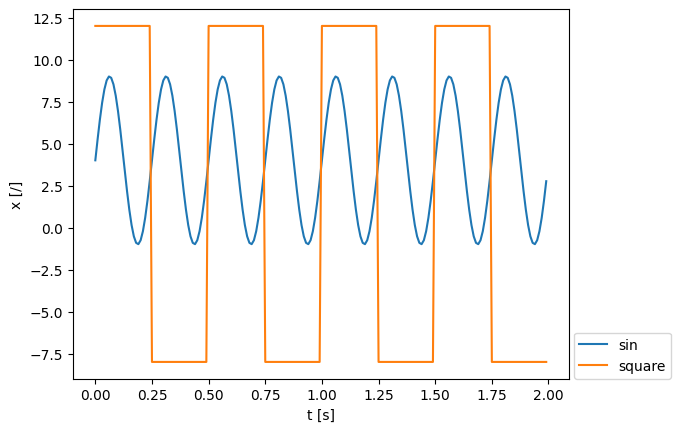

In [4]:
plt.figure()
plt.plot(t, x, label='sin')
plt.plot(t, y, label='square')
plt.xlabel('t [s]')
plt.ylabel('x [/]')
plt.legend(loc=(1.01, 0));

In [5]:
X = np.fft.rfft(x) / len(t) * 2
Y = np.fft.rfft(y) / len(t) * 2
freq = np.fft.rfftfreq(len(t), dt)

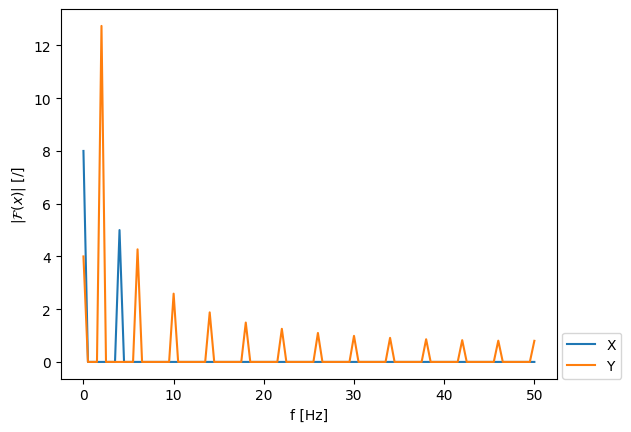

In [6]:
plt.figure()
plt.plot(freq, np.abs(X), label='X')
plt.plot(freq, np.abs(Y), label='Y')
plt.xlabel('f [Hz]')
plt.ylabel('$|\\mathcal{F}(x)|$ [/]')
plt.legend(loc=(1.01, 0));

**Prikaz lastnosti linearnosti:**

In [7]:
v = x + y
V = np.fft.rfft(v) / len(t) * 2

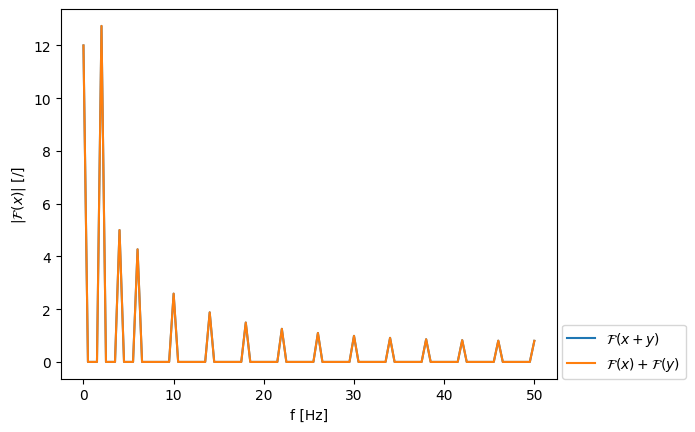

In [8]:
plt.figure()
plt.plot(freq, np.abs(V), label='$\\mathcal{F}(x+y)$')
plt.plot(freq, np.abs(X + Y), label='$\\mathcal{F}(x) + \\mathcal{F}(y)$')
plt.xlabel('f [Hz]')
plt.ylabel('$|\\mathcal{F}(x)|$ [/]')
plt.legend(loc=(1.01, 0));

**Uporaba linearnosti pri korekciji naloženega signala:**

In [10]:
V_Y = V - Y

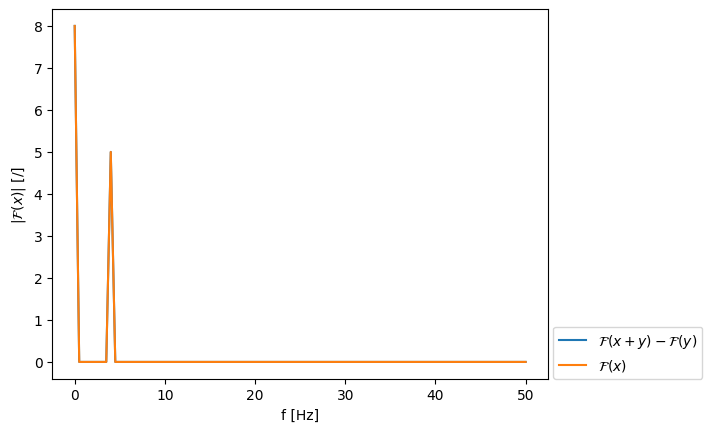

In [11]:
plt.figure()
plt.plot(freq, np.abs(V_Y), label='$\\mathcal{F}(x+y) - \\mathcal{F}(y)$')
plt.plot(freq, np.abs(X), label='$\\mathcal{F}(x)$')
plt.xlabel('f [Hz]')
plt.ylabel('$|\\mathcal{F}(x)|$ [/]')
plt.legend(loc=(1.01, 0));

Inverzna FFT razlike vsote signalov in naloženega signala:

In [13]:
v_y = np.fft.irfft(V_Y/2*len(t))

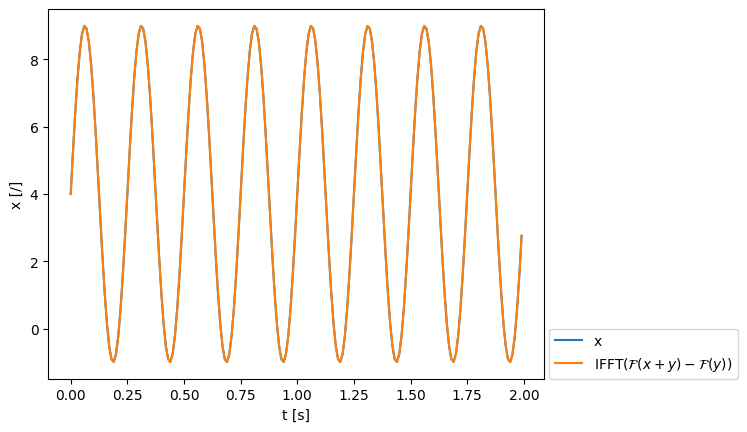

In [15]:
plt.figure()
plt.plot(t, x, label='x')
plt.plot(t, v_y, label='$\\mathrm{IFFT}(\\mathcal{F}(x+y) - \\mathcal{F}(y))$')
plt.xlabel('t [s]')
plt.ylabel('x [/]')
plt.legend(loc=(1.01, 0));

## Časovno skaliranje

:::{admonition} Časovno skaliranje
:class: note

$$
\mathcal{F}\{x(a\,t)\} = \frac{1}{|a|}\,X(f/a).
$$
:::

In [16]:
A = 1
p = 2
o = 0
a = 2

In [17]:
sin = lambda t, A, p, o: A*np.sin(2*np.pi*t*p) + o
x = sin(t, A, p, o)

In [18]:
at = np.arange(0, 2, a*dt)
y = sin(at, A, p, o)

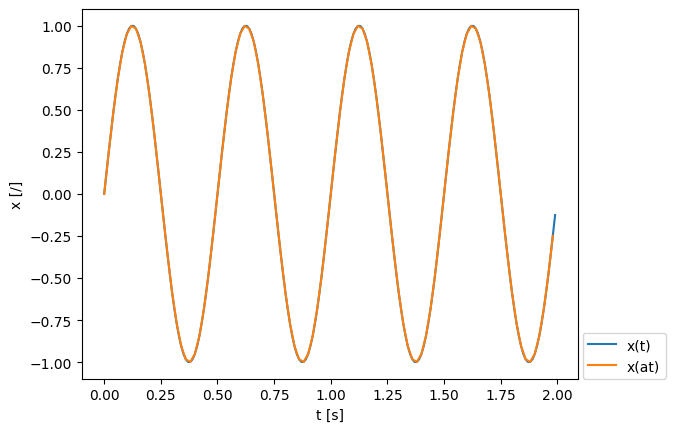

In [19]:
plt.figure()
plt.plot(t, x, label='x(t)')
plt.plot(at, y, label='x(at)')
plt.xlabel('t [s]')
plt.ylabel('x [/]')
plt.legend(loc=(1.01, 0));

Trajanje meritve je enako, a pri časovno skaliranem koraku $a \, \Delta t$:

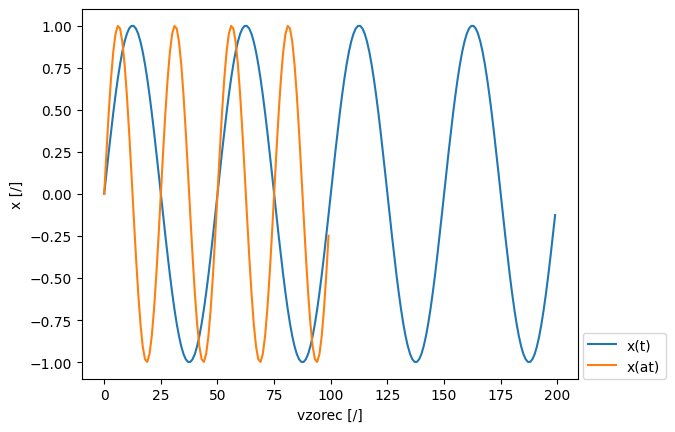

In [20]:
plt.figure()
plt.plot(x, label='x(t)')
plt.plot(y, label='x(at)')
plt.xlabel('vzorec [/]')
plt.ylabel('x [/]')
plt.legend(loc=(1.01, 0));

In [21]:
X = np.fft.rfft(x)
Y = np.fft.rfft(y)
freq = np.fft.rfftfreq(len(t), dt)
freq_a = np.fft.rfftfreq(len(at), a*dt)

Če časovno skaliranje poznamo in upoštevamo pri pretvorbi je rezultat pravilen:

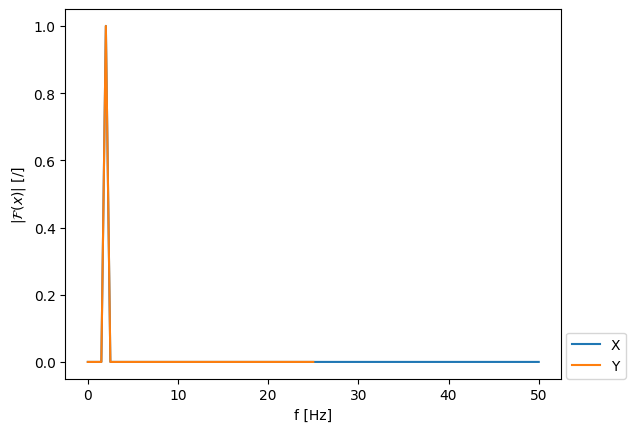

In [22]:
plt.figure()
plt.plot(freq, np.abs(X/len(t)*2), label='X')
plt.plot(freq_a, np.abs(Y/len(at)*2), label='Y')
plt.xlabel('f [Hz]')
plt.ylabel('$|\\mathcal{F}(x)|$ [/]')
plt.legend(loc=(1.01, 0)); 

Časovno skaliranje nam v tem primeru povzroča težave, če se ga pri meritvi **ne zavedamo**:

In [23]:
freq_a_s = np.fft.rfftfreq(len(at), dt)

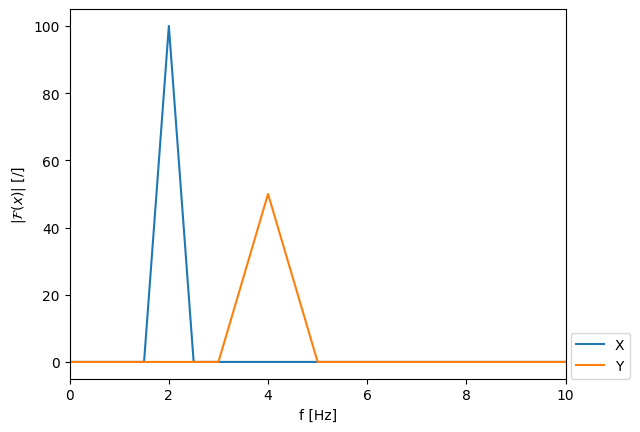

In [24]:
plt.figure()
plt.plot(freq, np.abs(X), label='X')
plt.plot(freq_a_s, np.abs(Y), label='Y')
plt.xlabel('f [Hz]')
plt.ylabel('$|\\mathcal{F}(x)|$ [/]')
plt.xlim(0, 10)
plt.legend(loc=(1.01, 0));

**Korekcija časovnega skaliranja**

$$
\mathcal{F}\{x(a\,t)\} = \frac{1}{|a|}\,X(f/a).
$$

Signal smo pretvorili v frekvenčno domeno pri frekvencah $f/a$, sedaj ga še narišimo pri $f/a$:

In [25]:
freq_a_popravek = freq_a_s / a

Popravek amplitude:

In [26]:
Y_popravek = np.abs(a) * Y

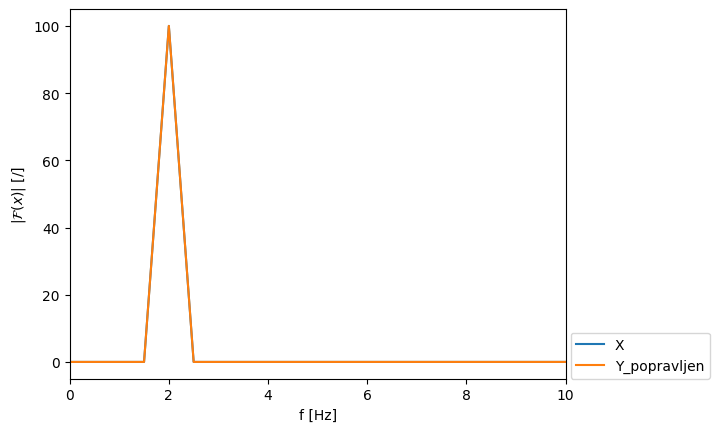

In [27]:
plt.figure()
plt.plot(freq, np.abs(X), label='X')
plt.plot(freq_a_popravek, np.abs(Y_popravek), label='Y_popravljen')
plt.xlabel('f [Hz]')
plt.ylabel('$|\\mathcal{F}(x)|$ [/]')
plt.xlim(0, 10)
plt.legend(loc=(1.01, 0));

## Časovni premik

:::{admonition} Časovni premik
:class: note

$$
\mathcal{F}\{x(t-t_0)\} = e^{-\textrm{i}\,2\pi\,f\,t_0}\,X(f).
$$
:::

In [28]:
A = 1
p = 2
o = 0
t_0 = 0.55

In [29]:
square = lambda t, A, p, o: A*signal.square(2*np.pi*t*p) + o

In [30]:
x = square(t, A, p, o)
y = square(t-t_0, A, p, o)

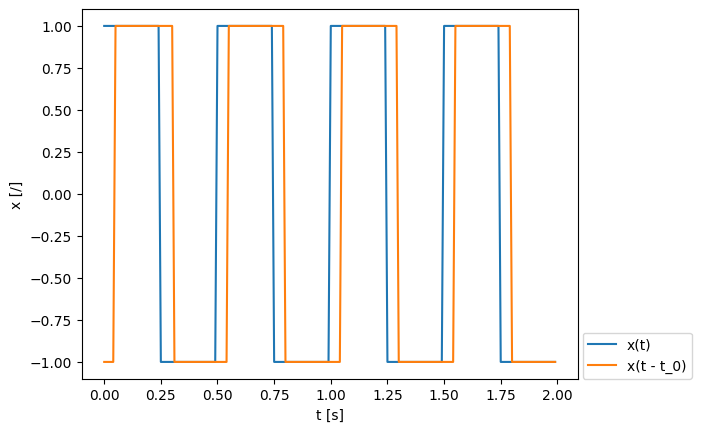

In [31]:
plt.figure()
plt.plot(t, x, label='x(t)')
plt.plot(t, y, label='x(t - t_0)')
plt.xlabel('t [s]')
plt.ylabel('x [/]')
plt.legend(loc=(1.01, 0));

In [32]:
X = np.fft.rfft(x)
Y = np.fft.rfft(y)
freq = np.fft.rfftfreq(len(t), dt)

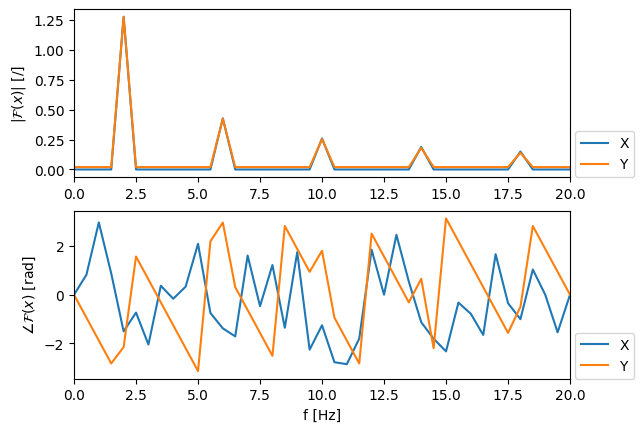

In [33]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(freq, np.abs(X/len(t)*2), label='X')
ax[0].plot(freq, np.abs(Y/len(t)*2), label='Y')
ax[0].set_ylabel('$|\\mathcal{F}(x)|$ [/]')
ax[0].set_xlim(0, 20)
ax[0].legend(loc=(1.01, 0));

ax[1].plot(freq, np.angle(X/len(t)*2), label='X')
ax[1].plot(freq, np.angle(Y/len(t)*2), label='Y')
ax[1].set_xlabel('f [Hz]')
ax[1].set_ylabel('$\\angle \\mathcal{F}(x)$ [rad]')
ax[1].set_xlim(0, 20)
ax[1].legend(loc=(1.01, 0)); 

In [34]:
X_shift = np.exp(-1j*2*np.pi*freq*t_0) * X

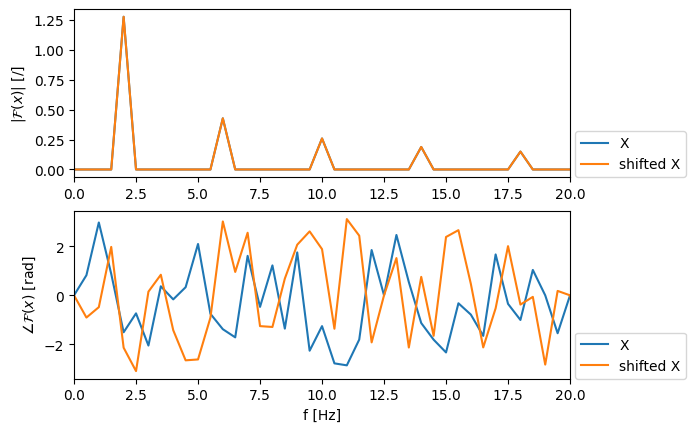

In [36]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(freq, np.abs(X/len(t)*2), label='X')
ax[0].plot(freq, np.abs(X_shift/len(t)*2), label='shifted X')
ax[0].set_ylabel('$|\\mathcal{F}(x)|$ [/]')
ax[0].set_xlim(0, 20)
ax[0].legend(loc=(1.01, 0));

ax[1].plot(freq, np.angle(X/len(t)*2), label='X')
ax[1].plot(freq, np.angle(X_shift/len(t)*2), label='shifted X')
ax[1].set_xlabel('f [Hz]')
ax[1].set_ylabel('$\\angle \\mathcal{F}(x)$ [rad]')
ax[1].set_xlim(0, 20)
ax[1].legend(loc=(1.01, 0)); 

Uspešnost časovnega premika preverimo v časovni domeni:

In [37]:
x_shift = np.fft.irfft(X_shift)

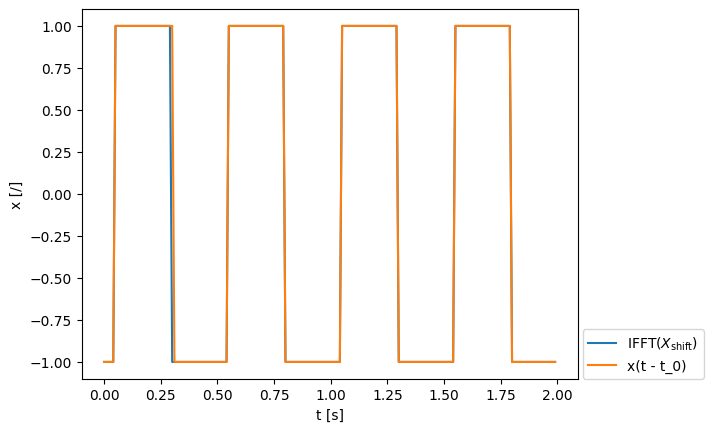

In [38]:
plt.figure()
plt.plot(t, x_shift, label='$\\mathrm{IFFT}(X_{\\mathrm{shift}})$')
plt.plot(t, y, label='x(t - t_0)')
plt.xlabel('t [s]')
plt.ylabel('x [/]')
plt.legend(loc=(1.01, 0))

## Amplitudna modulacija

:::{admonition} Amplitudna modulacija (frekvenčni zamik)
:class: note

$$
\mathcal{F}\{x(t)\,e^{\textrm{i}\,2\pi\,f_0\,t}\} = X(f-f_0).
$$

oziroma:

$$
\mathcal{F}\{x(t)\,\cos(2\pi\,f_0\,t)\} = \frac{1}{2}\big(X(f-f_0)+X(f+f_0)\big).
$$

:::

In [39]:
A = 1
p = 2
o = 0
f_0 = 1.

In [40]:
x = sin(t, A, p, o)
mod = np.cos(2*np.pi*f_0*t)
y = x * mod

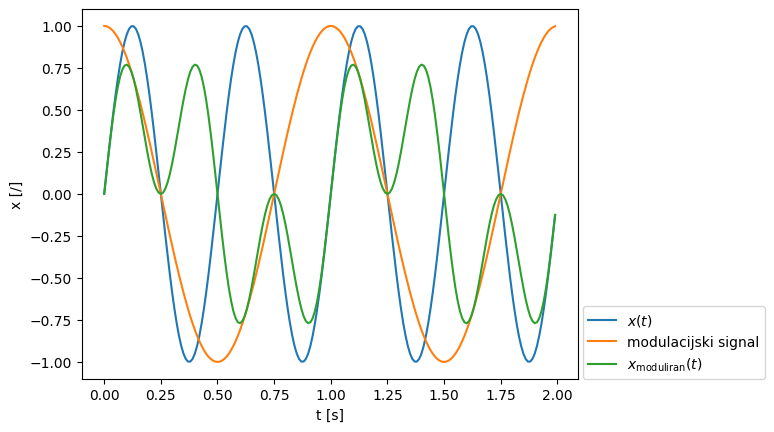

In [41]:
plt.figure()
plt.plot(t, x, label='$x(t)$')
plt.plot(t, mod, label='modulacijski signal')
plt.plot(t, y, label='$x_{\\mathrm{moduliran}}(t)$')
plt.xlabel('t [s]')
plt.ylabel('x [/]')
plt.legend(loc=(1.01, 0));

In [42]:
X = np.fft.rfft(x)
Y = np.fft.rfft(y)
freq = np.fft.rfftfreq(len(t), dt)

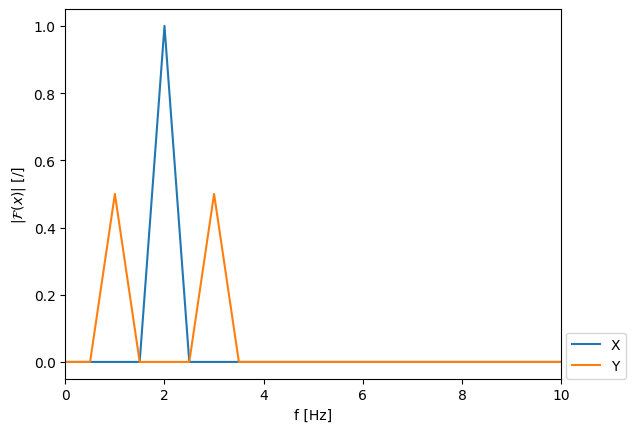

In [43]:
plt.figure()
plt.plot(freq, np.abs(X/len(t)*2), label='X')
plt.plot(freq, np.abs(Y/len(t)*2), label='Y')
plt.xlabel('f [Hz]')
plt.ylabel('$|\\mathcal{F}(x)|$ [/]')
plt.xlim(0, 10)
plt.legend(loc=(1.01, 0)); 

## Odvajanje in integriranje

:::{admonition} Odvajanje in integriranje

$$
\mathcal{F}\{\dot x(t)\} = \textrm{i}\,2\pi\,f\,X(f)
$$

in obratno:

$$
\mathcal{F}\big\{\int_{-\infty}^t x(\tau)\,\textrm{d}\tau\big\} = \frac{X(f)}{\textrm{i}\,2\pi\,f}.
$$

:::

In [44]:
A = 1
p = 2
o = 1.5

In [45]:
x = sin(t, A, p, o)

Spomnimo se:

$\frac{\mathrm{d}}{\mathrm{d} \, t}A \, \sin(a \, x) + o = A \, a \, \cos(a \, x)$

In [46]:
y = A*2*np.pi*p*np.cos(2*np.pi*t*p)

In [47]:
np.allclose(y, np.gradient(x, dt, edge_order=2), rtol=1e-2)

True

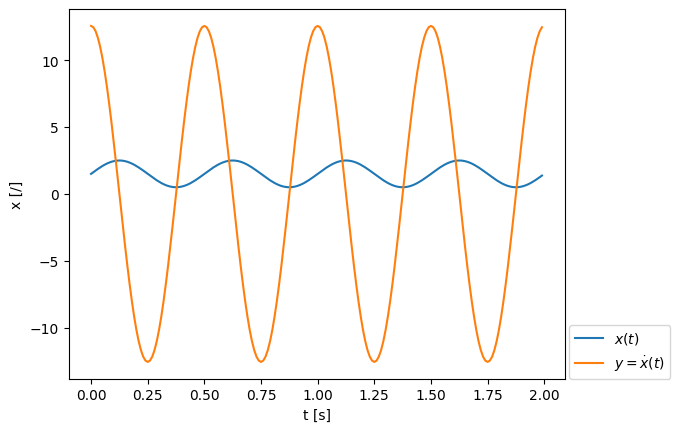

In [49]:
plt.figure()
plt.plot(t, x, label='$x(t)$')
plt.plot(t, y, label='$y = \\dot{x}(t)$')
plt.xlabel('t [s]')
plt.ylabel('x [/]')
plt.legend(loc=(1.01, 0));

In [50]:
X = np.fft.rfft(x) / len(t)
Y = np.fft.rfft(y) / len(t)
X[1:] *= 2
Y[1:] *= 2
freq = np.fft.rfftfreq(len(t), dt)

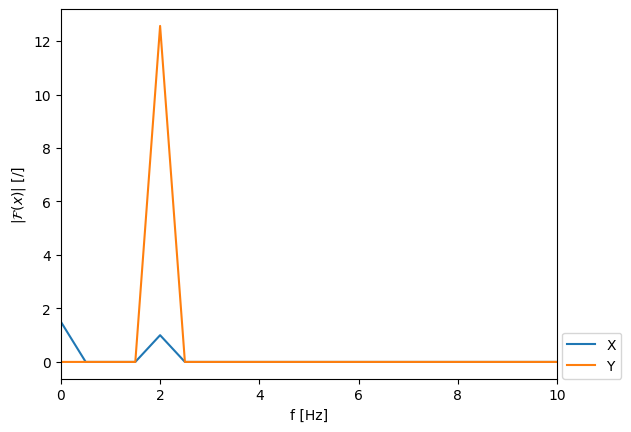

In [52]:
plt.figure()
plt.plot(freq, np.abs(X), label='X')
plt.plot(freq, np.abs(Y), label='Y')
plt.xlabel('f [Hz]')
plt.ylabel('$|\\mathcal{F}(x)|$ [/]')
plt.xlim(0, 10)
plt.legend(loc=(1.01, 0)); 

Odvod v frekvenčni domeni:

$\mathcal{F}(\dot{x}(t)) = \mathrm{i} \, \omega \, \mathcal{F}(x(t))$

In [53]:
omega = 2*np.pi*freq
dX = 1j*omega * X

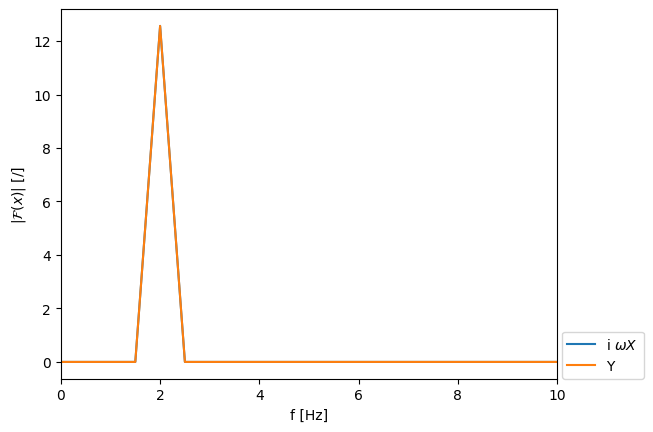

In [56]:
plt.figure()
plt.plot(freq, np.abs(dX), label='$\\mathrm{i} ~ \\omega X$')
plt.plot(freq, np.abs(Y), label='Y')
plt.xlabel('f [Hz]')
plt.ylabel('$|\\mathcal{F}(x)|$ [/]')
plt.xlim(0, 10)
plt.legend(loc=(1.01, 0)); 

Integral v frekvenčni domeni:

$\mathcal{F}(x(t)) = 1 / (\mathrm{i} \, \omega) \cdot \mathcal{F}(\dot{x}(t))$

In [57]:
omega[0] = 1e-6
ing_Y = 1 / (1j*omega) * Y

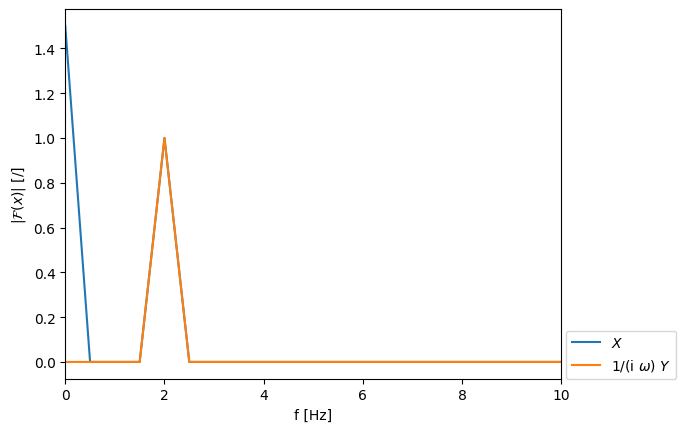

In [60]:
plt.figure()
plt.plot(freq, np.abs(X), label='$X$')
plt.plot(freq, np.abs(ing_Y), label='$1/(\\mathrm{i} ~ \\omega) ~ Y$')
plt.xlabel('f [Hz]')
plt.ylabel('$|\\mathcal{F}(x)|$ [/]')
plt.xlim(0, 10)
plt.legend(loc=(1.01, 0)); 

## Konvolucija in produkt funkcij


:::{admonition} Konvolucija in produkt funkcij
:class: note

$$
\mathcal{F} \big\{ x(t)*y(t) \big\} = X(f) \, Y(f)
$$

in 

$$
\mathcal{F} \big\{ x(t) \, y(t) \big\} = X(f)*Y(f)
$$
:::



:::{note}
Znak $*$ označuje konvolucijo:

$$
x(t)*y(t) = \int_{-\infty}^{+\infty} x(\tau)\,y(t-\tau)\,\textrm{d}\tau
$$
:::

Ker je produkt v frekvenčni domeni numerično veliko učinkovitejša operacija od konvolucije v časovni domeni, je to ena najpomembnejših lastnosti Fourierove transformacije!

Vizualizacija konvolucije na diskretnem signalu:

![convolve](./images/04/convolve_diskretno.gif)

In [61]:
A = 1
p = 3
o = 1.5

In [62]:
x = square(t, A, p, o)

In [63]:
X = np.fft.rfft(x) / len(t)
X[1:] *= 2
freq = np.fft.rfftfreq(len(t), dt)

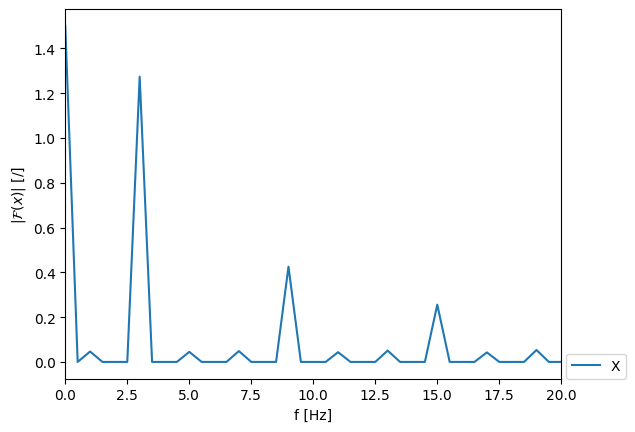

In [64]:
plt.figure()
plt.plot(freq, np.abs(X), label='X')
plt.xlabel('f [Hz]')
plt.ylabel('$|\\mathcal{F}(x)|$ [/]')
plt.xlim(0, 20)
plt.legend(loc=(1.01, 0)); 

Pripravimo pasovni frekvenčni filter, ki prepušča le v območju $(1.5, 4.5)$ Hz:

In [65]:
freq_band = np.array([1.5, 4.5]) 
b, a = signal.butter(3, freq_band, btype='bandpass', fs=fs)

Pripravimo frekvenčno prenosno funkcijo filtra $H(f)$:

In [66]:
w, H = signal.freqz(b, a, len(freq), whole=False, fs=fs)

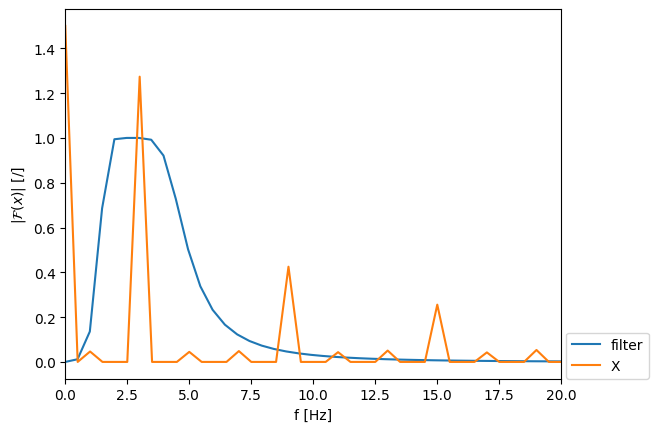

In [67]:
plt.figure()
plt.plot(w, np.abs(H), label='filter')
plt.plot(freq, np.abs(X), label='X')
plt.xlabel('f [Hz]')
plt.ylabel('$|\\mathcal{F}(x)|$ [/]')
plt.xlim(0, 20)
plt.legend(loc=(1.01, 0));

Filtrirajmo signal z **množenjem v frekvenčni domeni**:

In [68]:
X_filtriran = X * H

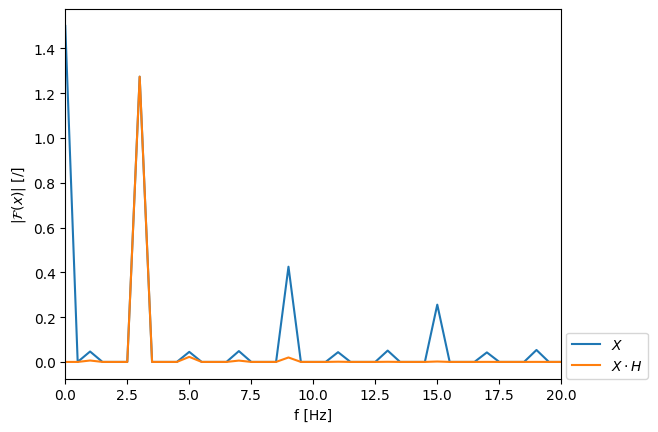

In [70]:
plt.figure()
plt.plot(freq, np.abs(X), label='$X$')
plt.plot(freq, np.abs(X_filtriran), label='$X \\cdot H$')
plt.xlabel('f [Hz]')
plt.ylabel('$|\\mathcal{F}(x)|$ [/]')
plt.xlim(0, 20)
plt.legend(loc=(1.01, 0));

Poglejmo še impulzno prenosno funkcijo filtra $h(t)$ (odziv filtra v času):

In [71]:
h = np.fft.irfft(H)

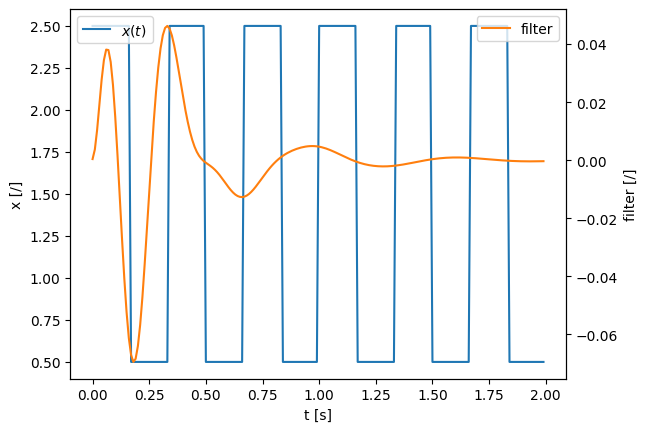

In [80]:
plt.figure()
plt.plot(t, x, label='$x(t)$')
plt.xlabel('t [s]')
plt.ylabel('x [/]')
plt.legend(loc=2);
ax2 = plt.gca().twinx()
ax2.plot(t, h, 'C1', label='filter')
ax2.set_ylabel('filter [/]')
ax2.legend(loc=1);

Filtrirajmo signal s **konvolucijo v časovni domeni**:

In [73]:
x_filtriran = signal.convolve(x, h, mode='full')[:len(x)]

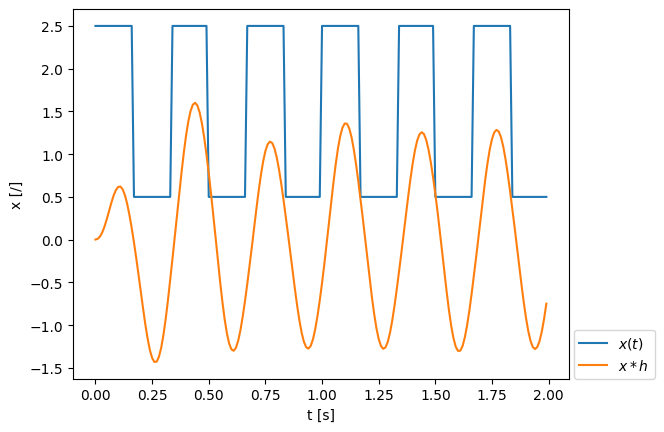

In [75]:
plt.figure()
plt.plot(t, x, label='$x(t)$')
plt.plot(t, x_filtriran, label='$x * h$')
plt.xlabel('t [s]')
plt.ylabel('x [/]')
plt.legend(loc=(1.01, 0));

Primerjajmo rezultata:

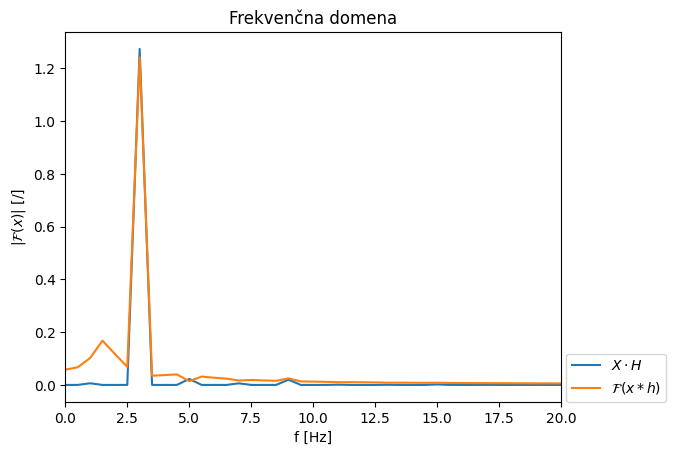

In [77]:
plt.figure()
plt.plot(freq, np.abs(X_filtriran), label='$X \\cdot H$')
plt.plot(freq, np.abs(np.fft.rfft(x_filtriran)*2/len(t)), label='$\\mathcal{F}(x*h)$')
plt.xlabel('f [Hz]')
plt.ylabel('$|\\mathcal{F}(x)|$ [/]')
plt.title('Frekvenčna domena')
plt.xlim(0, 20)
plt.legend(loc=(1.01, 0));

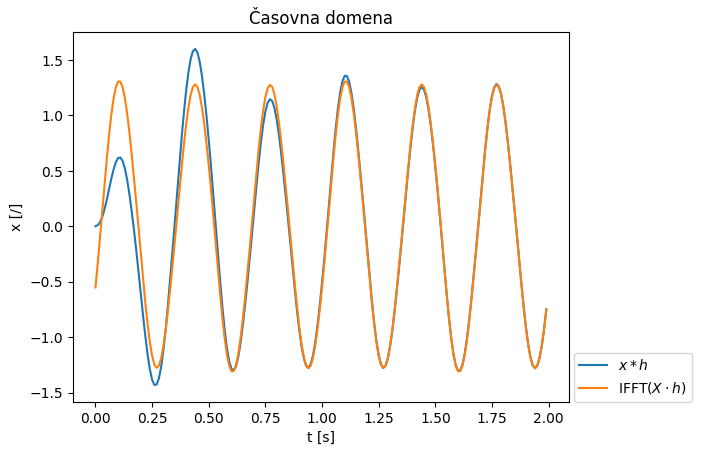

In [79]:
plt.figure()
plt.plot(t, x_filtriran, label='$x * h$')
plt.plot(t, np.fft.irfft(X_filtriran*len(t)/2), label='$\\mathrm{IFFT}(X \\cdot h)$')
plt.xlabel('t [s]')
plt.ylabel('x [/]')
plt.title('Časovna domena')
plt.legend(loc=(1.01, 0));

Razlika je posledica implementacije funkcije konvolucije ([`scipy.signal.convolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html)). Preverite vpliv parametra `mode`!